## RFM Analysis

### Step 1 : Reading and Understanding Data

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
update_month = '2021-10-01 00:00:00'

In [3]:
# Reading the data on which analysis needs to be done
deals_database = pd.read_csv('Deals Database.csv')
deals_database.head()

,Salesforce Account Id,Salesforce Deal Id,Name,Last Name,First Name,Original - Year Activated,Original - Month Activated,Original - Date Activated,Account Activated,Billing State/Province,...,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00
0,0013000000CcDuEAAV,a016000000Jp7qeAAB,"Aaroe, Paul M.",Aaroe,Paul M.,2009,August,2009-08-19,2009-08-19,PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0013000000CbIYyAAN,a010e00000r8uPlAAI,"Aaronson, Austin",Aaronson,Austin,2019,June,2019-06-25,2019-06-25,FL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0016000000cLphAAAS,a016000000aooYxAAI,"Abasi, Evelyn J.",Abasi,Evelyn J.,2014,March,2014-03-13,2014-03-13,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0013200001HEQegAAH,a013200000pZpYTAA0,"Abbitt, Julia Chico",Abbitt,Julia Chico,2017,February,2017-02-09,2017-02-09,WV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0013200001BYZ1bAAH,a013200000meskHAAQ,"Abdala, Dianna",Abdala,Dianna,2015,August,2015-08-04,2015-08-04,MA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To set the cut off point (date) from which to generate the data:

In [4]:
print("The index of Sales Office is " 
      + str(deals_database.columns.get_loc("Sales Office"))+".")

The index of Sales Office is 25.


In [5]:
df_val = pd.DataFrame(deals_database.iloc[:,26:(deals_database.columns.get_loc(update_month)+1)])

In [6]:
df = pd.concat([deals_database.loc[:,['Name', 'Salesforce Deal Id']], df_val], axis = 1)

To transpose the table using melt and only select columns with values:

In [7]:
df = pd.melt(df, id_vars = ['Name', 'Salesforce Deal Id']).dropna(subset = ['value'])
df = df[df.value != 0]

To rename the columns:

In [8]:
df.rename(columns = {'variable':'InvoiceDate', 'value':'Amount'}, inplace = True)
df.head()

,Name,Salesforce Deal Id,InvoiceDate,Amount
16,"Abney, C. Gregory",a016000000I881yAAB,2009-01-01 00:00:00,323.0
29,"Abramovitch, Tina J.",a016000000I7vB6AAJ,2009-01-01 00:00:00,595.0
30,"Abramovitch, Tina J.",a016000000I7vCdAAJ,2009-01-01 00:00:00,405.0
42,"Abrams, Gary D.",a016000000HUsbWAAT,2009-01-01 00:00:00,800.0
45,"Abrams, Matthew E.",a016000000HUsSZAA1,2009-01-01 00:00:00,575.0


In [9]:
df.shape # Get the shape of the dataframe

(210998, 4)

In [10]:
df.info() # get the df info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210998 entries, 16 to 2204047
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                210998 non-null  object 
 1   Salesforce Deal Id  210998 non-null  object 
 2   InvoiceDate         210998 non-null  object 
 3   Amount              210998 non-null  float64
dtypes: float64(1), object(3)
memory usage: 8.0+ MB


In [11]:
df.describe() # df description

,Amount
count,210998.000000
mean,704.303107
std,459.956979
min,5.500000
25%,445.750000
50%,595.000000
75%,814.937500
max,13643.520000


### Step 2 : Data Cleansing

To calculate the % of missing values in the dataframe:

In [12]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

Name                  0.0
Salesforce Deal Id    0.0
InvoiceDate           0.0
Amount                0.0
dtype: float64

To drop rows with missing values:

In [13]:
df = df.dropna()
df.shape

(210998, 4)

To change the datatype of InvoiceDate from string to datetime:

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Step 3 : Data Preparation

We are going to perform an analysis based on the following factors:
* R (Recency): Number of days since last purchase/payment
* F (Frequency): Number of tracsactions
* M (Monetary): Total amount of transactions (revenue contribution)

#### For the Monetary attribute:

In [15]:
rfm_m = df.groupby('Name')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,Name,Amount
0,"Aaroe, Paul M.",8760.0
1,"Aaronson, Austin",5425.0
2,"Abasi, Evelyn J.",9997.4
3,"Abbitt, Julia Chico",2975.0
4,"Abdala, Dianna",20250.0


#### For the Frequency Attribute:

In [16]:
rfm_f = df.groupby('Name')['InvoiceDate'].count() #you can also use other columns here
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Name', 'Frequency']
rfm_f.head()

,Name,Frequency
0,"Aaroe, Paul M.",24
1,"Aaronson, Austin",5
2,"Abasi, Evelyn J.",21
3,"Abbitt, Julia Chico",7
4,"Abdala, Dianna",15


To merge the two dataframes:

In [17]:
rfm = pd.merge(rfm_m, rfm_f, on='Name', how='inner')
rfm.head()

,Name,Amount,Frequency
0,"Aaroe, Paul M.",8760.0,24
1,"Aaronson, Austin",5425.0,5
2,"Abasi, Evelyn J.",9997.4,21
3,"Abbitt, Julia Chico",2975.0,7
4,"Abdala, Dianna",20250.0,15


#### For the Recency attribute:

To compute the maximum date to know the last transaction date:

In [18]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2021-10-01 00:00:00')

To compute the difference between maximum date and Invoice Date:

In [19]:
df['Diff'] = max_date - df['InvoiceDate']
df.head()

,Name,Salesforce Deal Id,InvoiceDate,Amount,Diff
16,"Abney, C. Gregory",a016000000I881yAAB,2009-01-01,323.0,4656 days
29,"Abramovitch, Tina J.",a016000000I7vB6AAJ,2009-01-01,595.0,4656 days
30,"Abramovitch, Tina J.",a016000000I7vCdAAJ,2009-01-01,405.0,4656 days
42,"Abrams, Gary D.",a016000000HUsbWAAT,2009-01-01,800.0,4656 days
45,"Abrams, Matthew E.",a016000000HUsSZAA1,2009-01-01,575.0,4656 days


To compute last transaction date to get the recency of customers:

In [20]:
rfm_p = df.groupby('Name')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,Name,Diff
0,"Aaroe, Paul M.",3745 days
1,"Aaronson, Austin",731 days
2,"Abasi, Evelyn J.",2161 days
3,"Abbitt, Julia Chico",1522 days
4,"Abdala, Dianna",1826 days


To get the exact number of days:

In [21]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,Name,Diff
0,"Aaroe, Paul M.",3745
1,"Aaronson, Austin",731
2,"Abasi, Evelyn J.",2161
3,"Abbitt, Julia Chico",1522
4,"Abdala, Dianna",1826


Add one day to the 'Diff' column to avoid -inf in the log conversion:

In [22]:
rfm_p['Diff'] = rfm_p['Diff'] + 1

 To merge tha dataframes to get the final RFM dataframe:

In [23]:
rfm = pd.merge(rfm, rfm_p, on='Name', how='inner')
rfm.columns = ['Name', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Name,Amount,Frequency,Recency
0,"Aaroe, Paul M.",8760.0,24,3746
1,"Aaronson, Austin",5425.0,5,732
2,"Abasi, Evelyn J.",9997.4,21,2162
3,"Abbitt, Julia Chico",2975.0,7,1523
4,"Abdala, Dianna",20250.0,15,1827


### Outliers

Note: This is still subject to discussion. For now, we have not removed the outliers.

There are 2 types of outliers and we will treat outliers as it can skew our dataset:
* Statistical
* Domain specific

Text(0.5, 0, 'Attributes')

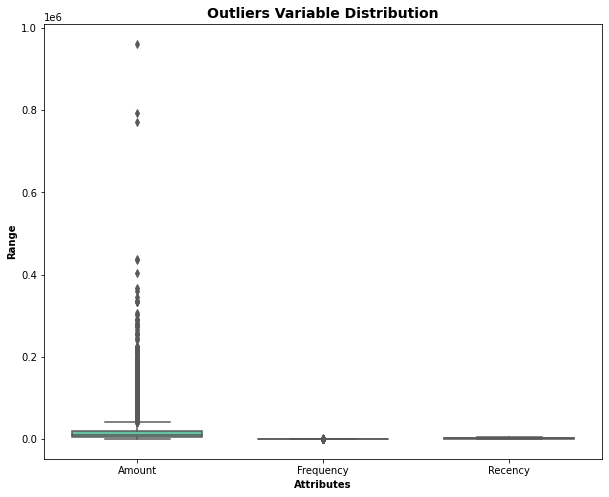

In [24]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

To remove the statistical outliers for Amount:

In [25]:
#Q1 = rfm.Amount.quantile(0.05)
#Q3 = rfm.Amount.quantile(0.95)
#IQR = Q3 - Q1
#rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

To remove statistical outliers for Recency:

In [26]:
#Q1 = rfm.Recency.quantile(0.05)
#Q3 = rfm.Recency.quantile(0.95)
#IQR = Q3 - Q1
#rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

To remove statistical outliers for Frequency:

In [27]:
#Q1 = rfm.Frequency.quantile(0.05)
#Q3 = rfm.Frequency.quantile(0.95)
#IQR = Q3 - Q1
#rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

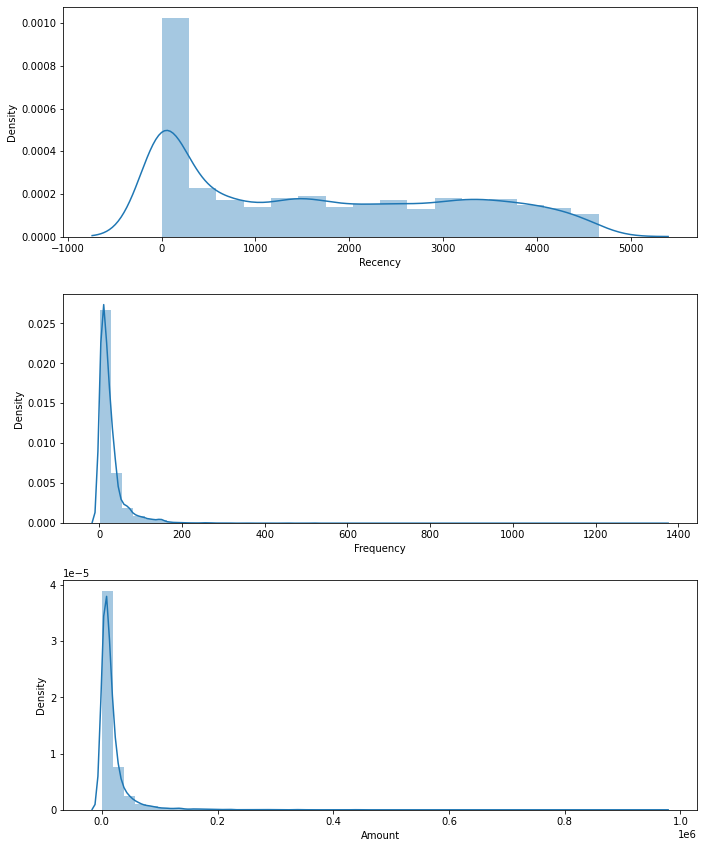

In [28]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Amount, label = 'Amount')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [29]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'Amount']].apply(np.log, axis = 1).round(3)
#or rfm_log = np.log(rfm_rfm)

In [30]:
rfm_log.describe()

,Recency,Frequency,Amount
count,7938.000000,7938.000000,7938.000000
mean,5.603491,2.704622,9.147069
std,3.240952,1.127373,1.183730
min,0.000000,0.000000,5.288000
25%,4.127000,1.946000,8.461000
50%,7.266000,2.833000,9.200000
75%,8.001000,3.466000,9.879750
max,8.446000,7.213000,13.777000


C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DataAnalyst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

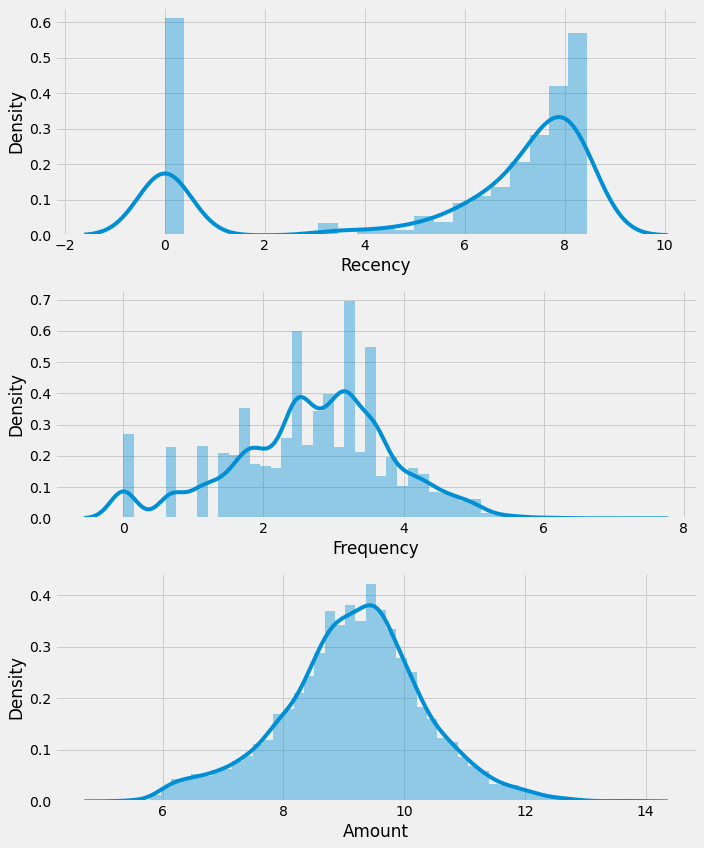

In [31]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Amount, label = 'Amount')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

#### Rescaling the attributes:

It is extremely important to rescale the variables so that they have a comparable scale. There are two common ways of rescaling:

* Min-Max scaling
* Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [32]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(7938, 3)

To convert the array to a dataframe:

In [33]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.293017,-0.069516,1.401634
1,-0.391122,-0.581307,-0.620721
2,-0.256617,-0.150325,0.338791
3,-0.463193,-0.527434,-0.089970
4,0.044981,-0.311943,0.114010


### Step 4: Modelling

K-means clustering is one of the simplest and popular unsupervised machine learning algorithm.

The algorithm works as follows:

* First we initialize k points, called means, randomly.
* We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
* We repeat the process for a given number of iterations and at the end, we have our clusters.

In [34]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [35]:
kmeans.labels_

array([0, 3, 0, ..., 0, 0, 1])

#### Finding the Optimal Number of Clusters

_Elbow Curve to get the right number of Clusters_

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

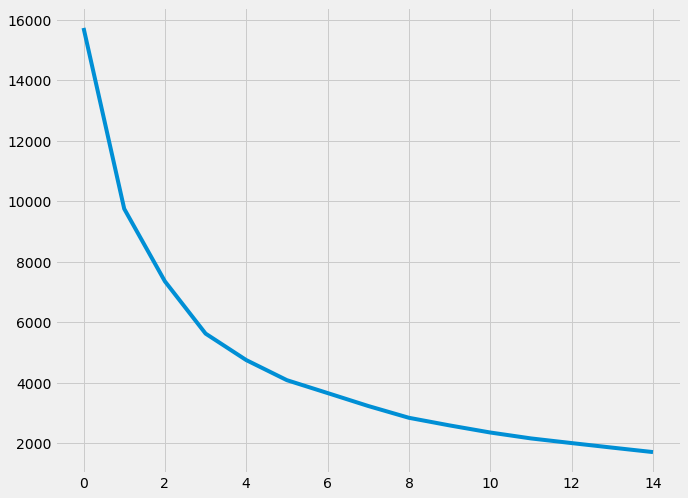

In [36]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

#### Silhoutte Analysis

p is the mean distance to the points in the nearest cluster that the data point is not a part of

q is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1.

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

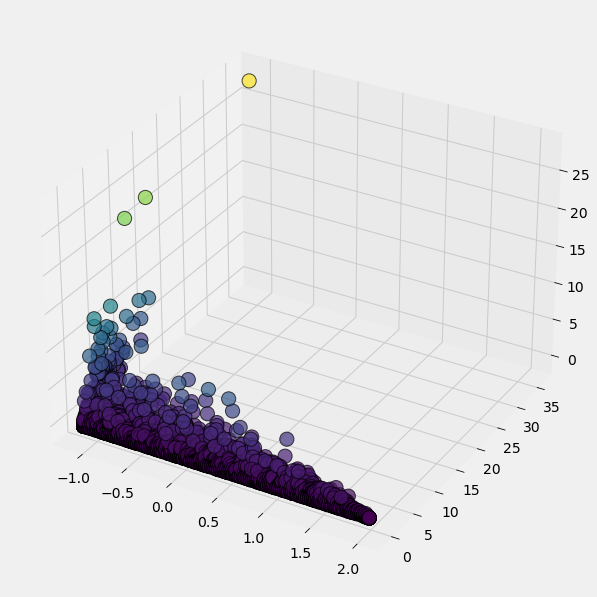

In [37]:
#create a 3D scatter plot for the df
X = rfm_df_scaled['Recency']
y = rfm_df_scaled['Frequency']
z = rfm_df_scaled['Amount']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

In [38]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6525616087308104
For n_clusters=3, the silhouette score is 0.4958937403713729
For n_clusters=4, the silhouette score is 0.5167900519336369
For n_clusters=5, the silhouette score is 0.5176425150571027
For n_clusters=6, the silhouette score is 0.42874782464174993
For n_clusters=7, the silhouette score is 0.4307905145351296
For n_clusters=8, the silhouette score is 0.4312652632673643


In [39]:
# Final model with k=5
# edit the number of clusters
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=5)

In [40]:
kmeans.labels_

array([4, 1, 4, ..., 4, 4, 0])

To assign the labels:

In [41]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Name,Amount,Frequency,Recency,Cluster_Id
0,"Aaroe, Paul M.",8760.0,24,3746,4
1,"Aaronson, Austin",5425.0,5,732,1
2,"Abasi, Evelyn J.",9997.4,21,2162,4
3,"Abbitt, Julia Chico",2975.0,7,1523,1
4,"Abdala, Dianna",20250.0,15,1827,1


To create a box plot to visualize Cluster ID vs. Recency:

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

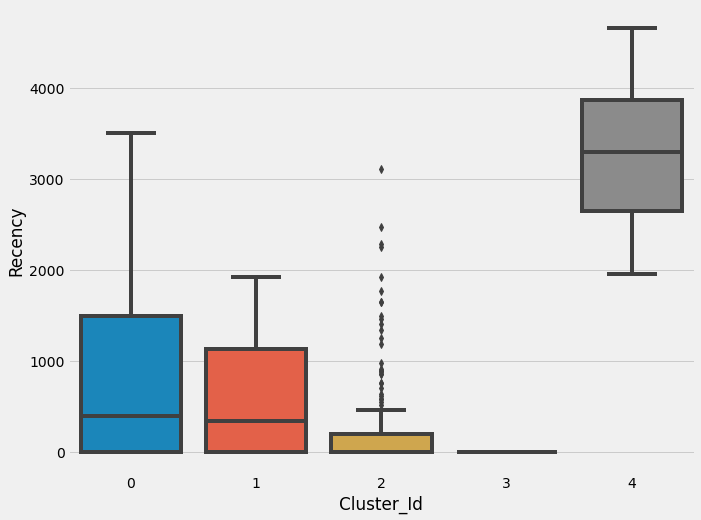

In [42]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

To create a box plot to visualize Cluster ID vs. Frequency:

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

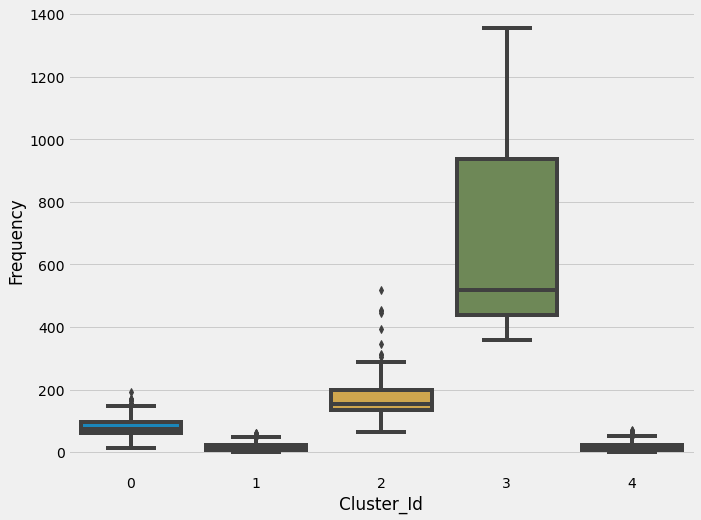

In [43]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

To create a box plot to visualize Cluster ID vs. Monetary:

<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

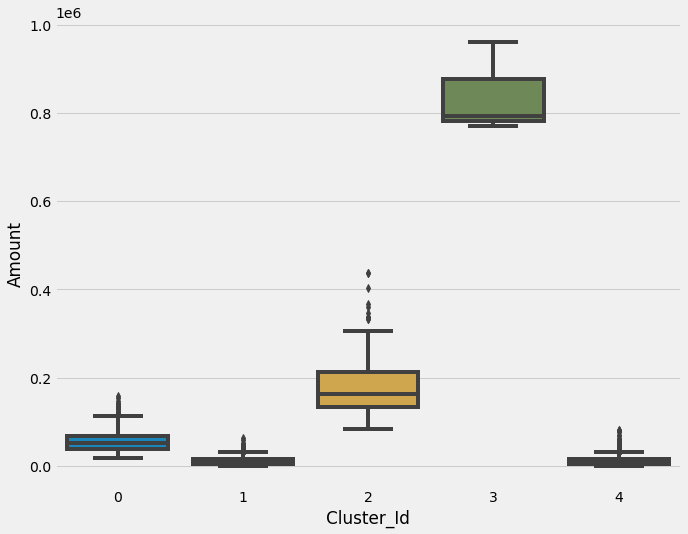

In [44]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

In [45]:
rfm['Cluster_Id'].value_counts()

1    3873
4    3137
0     786
2     139
3       3
Name: Cluster_Id, dtype: int64

#### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

* Divisive
* Agglomerative.

_Single Linkage:_

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.

In [46]:
# Single linkage: 

#mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
#dendrogram(mergings)
#plt.show()

_Complete Linkage_

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

In [47]:
# Complete linkage

#mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
#dendrogram(mergings)
#plt.show()

_Average Linkage:_

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.

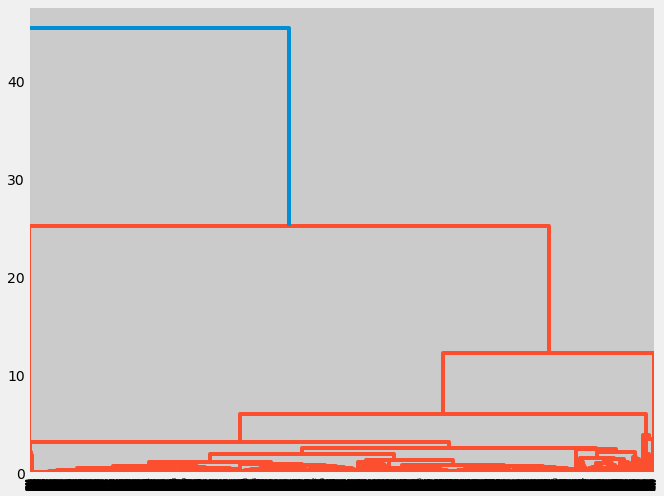

In [48]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Cutting the Dendogram based on K

In [49]:
# edit the number of clusters
cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

To assign cluster labels:

In [50]:
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,Name,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,"Aaroe, Paul M.",8760.0,24,3746,4,0
1,"Aaronson, Austin",5425.0,5,732,1,0
2,"Abasi, Evelyn J.",9997.4,21,2162,4,0
3,"Abbitt, Julia Chico",2975.0,7,1523,1,0
4,"Abdala, Dianna",20250.0,15,1827,1,0


To create a box plot to visualize Cluster Label vs. Recency:

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

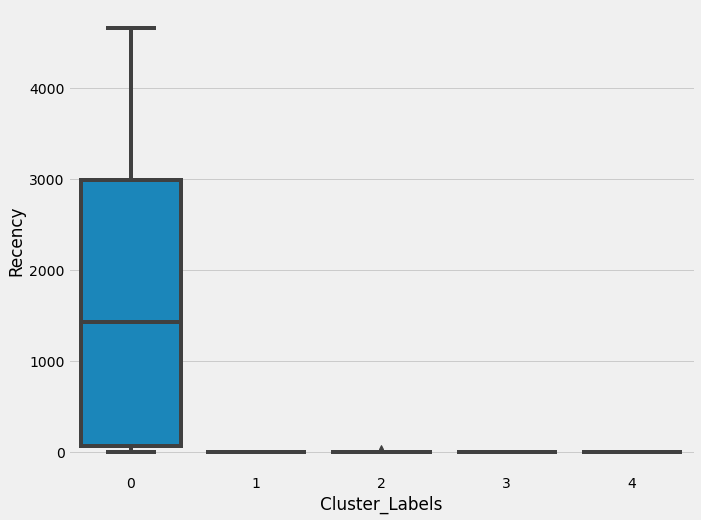

In [51]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

To create a box plot to visualize Cluster Label vs. Frequency:

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

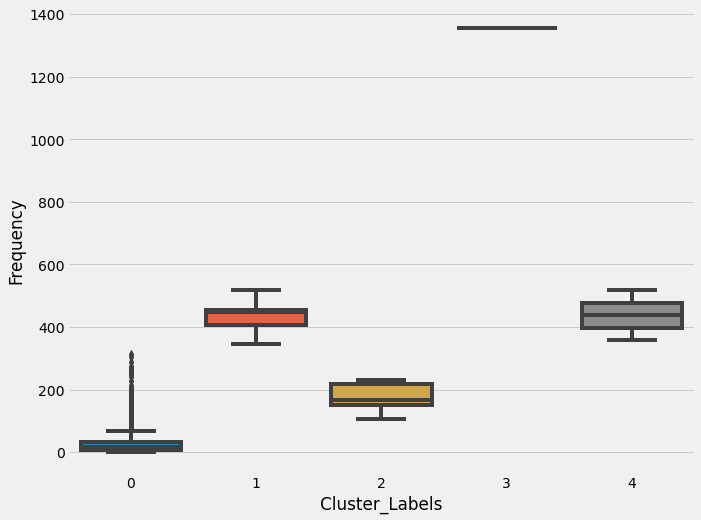

In [52]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

To create a box plot to visualize Cluster Label vs. Amount:

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

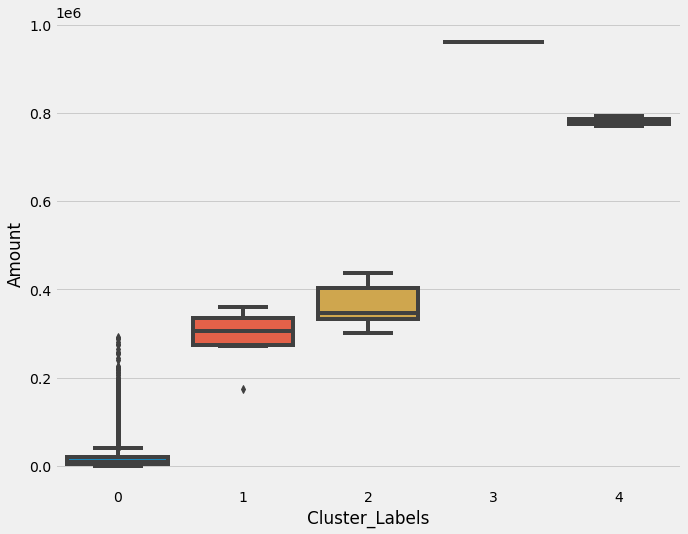

In [53]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

In [54]:
rfm["Cluster_Labels"].value_counts()

0    7920
2       9
1       6
4       2
3       1
Name: Cluster_Labels, dtype: int64

#### Snake Plot

In [55]:
#Replace actual value with the scaled values:
rfm_formerge = rfm[['Name', 'Cluster_Id', 'Cluster_Labels']]
rfm_normalized = rfm_formerge.merge(rfm_df_scaled, left_index=True, right_index=True)

In [56]:
rfm_normalized

,Name,Cluster_Id,Cluster_Labels,Amount,Frequency,Recency
0,"Aaroe, Paul M.",4,0,-0.293017,-0.069516,1.401634
1,"Aaronson, Austin",1,0,-0.391122,-0.581307,-0.620721
2,"Abasi, Evelyn J.",4,0,-0.256617,-0.150325,0.338791
3,"Abbitt, Julia Chico",1,0,-0.463193,-0.527434,-0.089970
4,"Abdala, Dianna",1,0,0.044981,-0.311943,0.114010
...,...,...,...,...,...,...
7933,"Zuckerbrod, Todd A.",1,0,-0.307961,-0.392753,-0.192631
7934,"Zuckerman, Paul S.",0,0,1.835546,-0.392753,-0.192631
7935,"Zuganelis, George M.",4,0,-0.521291,-0.689053,1.829724
7936,"Zuspan, Philip",4,0,-0.130696,0.011293,1.483495


In [57]:
#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized,id_vars=['Name','Cluster_Id','Cluster_Labels'],value_vars=['Recency', 'Frequency', 'Amount'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,Name,Cluster_Id,Cluster_Labels,Metric,Value
0,"Aaroe, Paul M.",4,0,Recency,1.401634
1,"Aaronson, Austin",1,0,Recency,-0.620721
2,"Abasi, Evelyn J.",4,0,Recency,0.338791
3,"Abbitt, Julia Chico",1,0,Recency,-0.089970
4,"Abdala, Dianna",1,0,Recency,0.114010


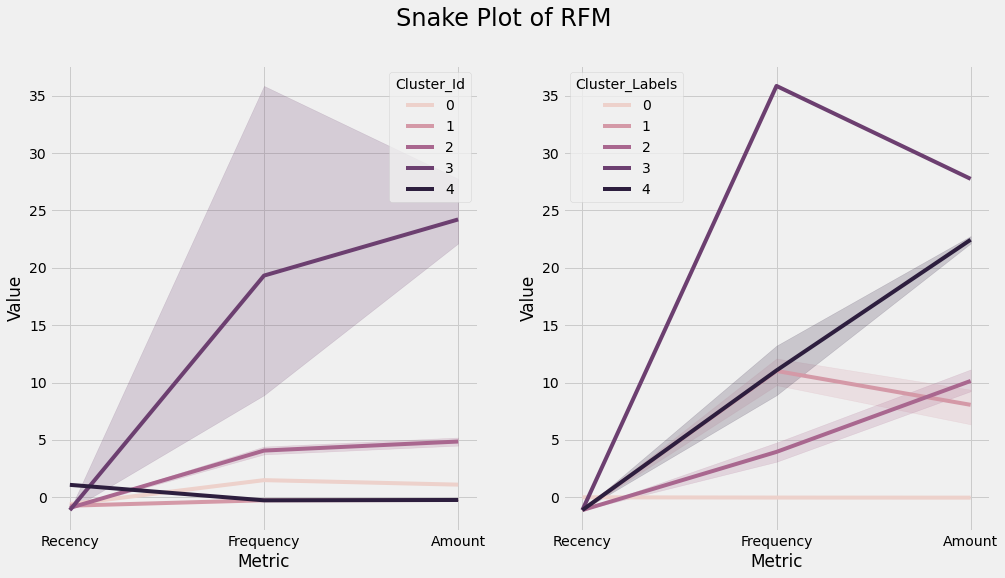

In [58]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Cluster_Id', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Cluster_Labels', data = rfm_melt,ax=ax2)

plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 
plt.show()

#### Heatmap

In [59]:
rfm

,Name,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,"Aaroe, Paul M.",8760.000,24,3746,4,0
1,"Aaronson, Austin",5425.000,5,732,1,0
2,"Abasi, Evelyn J.",9997.400,21,2162,4,0
3,"Abbitt, Julia Chico",2975.000,7,1523,1,0
4,"Abdala, Dianna",20250.000,15,1827,1,0
...,...,...,...,...,...,...
7933,"Zuckerbrod, Todd A.",8252.000,12,1370,1,0
7934,"Zuckerman, Paul S.",81119.000,12,1370,0,0
7935,"Zuganelis, George M.",1000.000,1,4384,4,0
7936,"Zuspan, Philip",14278.000,27,3868,4,0


In [60]:
rfm_cluster = rfm_normalized[['Recency', 'Frequency', 'Amount', 'Cluster_Id']]

In [61]:
rfm_pop= rfm_normalized[['Recency', 'Frequency', 'Amount']]

In [62]:
rfm_cluster

,Recency,Frequency,Amount,Cluster_Id
0,1.401634,-0.069516,-0.293017,4
1,-0.620721,-0.581307,-0.391122,1
2,0.338791,-0.150325,-0.256617,4
3,-0.089970,-0.527434,-0.463193,1
4,0.114010,-0.311943,0.044981,1
...,...,...,...,...
7933,-0.192631,-0.392753,-0.307961,1
7934,-0.192631,-0.392753,1.835546,0
7935,1.829724,-0.689053,-0.521291,4
7936,1.483495,0.011293,-0.130696,4


In [63]:
rfm_pop

,Recency,Frequency,Amount
0,1.401634,-0.069516,-0.293017
1,-0.620721,-0.581307,-0.391122
2,0.338791,-0.150325,-0.256617
3,-0.089970,-0.527434,-0.463193
4,0.114010,-0.311943,0.044981
...,...,...,...
7933,-0.192631,-0.392753,-0.307961
7934,-0.192631,-0.392753,1.835546
7935,1.829724,-0.689053,-0.521291
7936,1.483495,0.011293,-0.130696


In [64]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_normalized.groupby(['Cluster_Id']).mean()
population_avg = rfm_normalized.mean()
relative_imp = cluster_avg / (population_avg - 1)
relative_imp.drop(columns=['Cluster_Id', 'Cluster_Labels'], axis=1, inplace=True)
relative_imp.round(4)

,Amount,Frequency,Recency
Cluster_Id,,,
0,-1.1063,-1.4980,0.5915
1,0.2318,0.2550,0.7270
2,-4.8615,-4.0736,0.9203
3,-24.2077,-19.3157,1.1112
4,0.2296,0.2594,-1.0877


In [65]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_normalized.groupby(['Cluster_Labels']).mean()
population_avg = rfm_normalized.mean()
prop_rfm = cluster_avg / (population_avg - 1)
prop_rfm.drop(columns=['Cluster_Id', 'Cluster_Labels'], axis=1, inplace=True)
prop_rfm.round(4)

,Amount,Frequency,Recency
Cluster_Labels,,,
0,0.0268,0.0202,-0.0025
1,-8.0591,-11.0103,1.1112
2,-10.1369,-3.9590,1.1090
3,-27.7432,-35.8367,1.1112
4,-22.4400,-11.0552,1.1112


In [66]:
population_avg

Cluster_Id        2.104812e+00
Cluster_Labels    4.409171e-03
Amount            2.198628e-17
Frequency         1.042810e-16
Recency          -5.339924e-17
dtype: float64

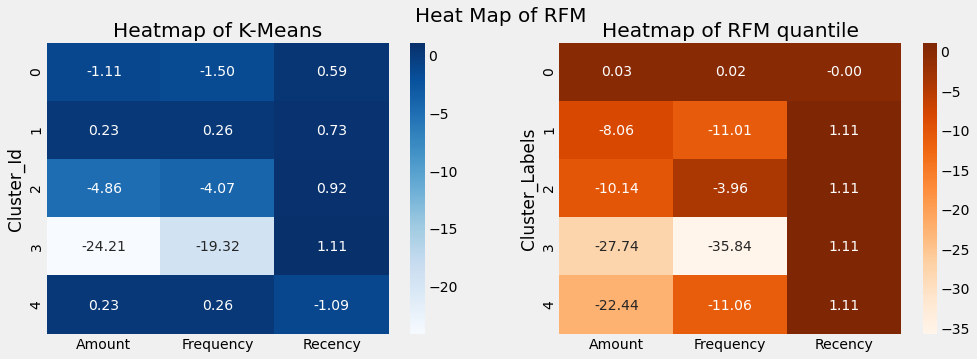

In [67]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()

### Step 5: Final Analysis

K-Means Clustering with 5 Cluster IDs

* Attorneys under Cluster ID 3 & 4 have the highest amount and most frequent transactions. Just put them into one cluster since Cluster ID 4 has only 3 Attorneys (they may be outliers or super VIPs).
* Attorneys under Cluster ID 0 are 3rd in terms of both amount and frequency of transactions (after 3 & 4).
* Attorneys under Cluster ID 2 and 1 are the the least frequent and low-value payors. However, Cluster ID 1 have not transacted with the company for the longest time.

Hierarchical Clustering with 4 Cluster Labels

* Attorneys under Cluster Label 2 have the highest amount of and have frequent transactions.
* Attorneys under Cluster Label 0 the the least frequent and low-value payors.

To export results:

In [68]:
rfm.to_csv('rfm analysis_final.csv', index = False)

Add details:

In [69]:
status = deals_database[['Name', 'Status']]

In [70]:
df_status = status.sort_values(['Name','Status']).drop_duplicates('Name')[['Name','Status']]

In [71]:
df_status

,Name,Status
0,"Aaroe, Paul M.",Inactive
1,"Aaronson, Austin",Inactive
2,"Abasi, Evelyn J.",Inactive
3,"Abbitt, Julia Chico",Inactive
4,"Abdala, Dianna",Inactive
...,...,...
14299,"Zuckerbrod, Todd A.",Inactive
14300,"Zuckerman, Paul S.",Inactive
14301,"Zuganelis, George M.",Inactive
14302,"Zuspan, Philip",Inactive


In [72]:
state = deals_database[['Name', 'Salesforce Account Id', 'Billing State/Province', 'State']]

In [73]:
df_state = state.drop_duplicates(subset='Name', keep='last')

In [74]:
df_state

,Name,Salesforce Account Id,Billing State/Province,State
0,"Aaroe, Paul M.",0013000000CcDuEAAV,PA,Pennsylvania
1,"Aaronson, Austin",0013000000CbIYyAAN,FL,Florida
2,"Abasi, Evelyn J.",0016000000cLphAAAS,CA,California
3,"Abbitt, Julia Chico",0013200001HEQegAAH,WV,West Virginia
4,"Abdala, Dianna",0013200001BYZ1bAAH,MA,Massachusetts
...,...,...,...,...
14299,"Zuckerbrod, Todd A.",0016000000o6Us5AAE,FL,Florida
14300,"Zuckerman, Paul S.",0013000000CbadyAAB,CA,California
14301,"Zuganelis, George M.",0013000000Cbb8cAAB,IL,Illinois
14304,"Zuspan, Philip",0013000000CbeEQAAZ,MO,Missouri


In [75]:
rfm_details = rfm.merge(df_status,on='Name', how='left')
rfm_details = rfm_details.merge(df_state,on='Name', how='left')

In [76]:
rfm_filtered = rfm_details[["Name", "Salesforce Account Id", "Amount", 
                           "Frequency", "Recency", "Cluster_Id", "Cluster_Labels", 
                           "Status", "Billing State/Province", "State"]]

In [77]:
rfm_filtered

,Name,Salesforce Account Id,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels,Status,Billing State/Province,State
0,"Aaroe, Paul M.",0013000000CcDuEAAV,8760.000,24,3746,4,0,Inactive,PA,Pennsylvania
1,"Aaronson, Austin",0013000000CbIYyAAN,5425.000,5,732,1,0,Inactive,FL,Florida
2,"Abasi, Evelyn J.",0016000000cLphAAAS,9997.400,21,2162,4,0,Inactive,CA,California
3,"Abbitt, Julia Chico",0013200001HEQegAAH,2975.000,7,1523,1,0,Inactive,WV,West Virginia
4,"Abdala, Dianna",0013200001BYZ1bAAH,20250.000,15,1827,1,0,Inactive,MA,Massachusetts
...,...,...,...,...,...,...,...,...,...,...
7933,"Zuckerbrod, Todd A.",0016000000o6Us5AAE,8252.000,12,1370,1,0,Inactive,FL,Florida
7934,"Zuckerman, Paul S.",0013000000CbadyAAB,81119.000,12,1370,0,0,Inactive,CA,California
7935,"Zuganelis, George M.",0013000000Cbb8cAAB,1000.000,1,4384,4,0,Inactive,IL,Illinois
7936,"Zuspan, Philip",0013000000CbeEQAAZ,14278.000,27,3868,4,0,Inactive,MO,Missouri


In [78]:
rfm_filtered.to_csv('rfm analysis_final_with_details.csv', index = False)

In [79]:
print('The End.')

The End.


### For Churn Analysis (Ad Hoc)

In [80]:
for_merge = deals_database[['Salesforce Deal Id', 'Area of Practice']].drop_duplicates(subset=['Salesforce Deal Id'], keep='first')

In [81]:
for_merge

,Salesforce Deal Id,Area of Practice
0,a016000000Jp7qeAAB,Criminal Law;;;;
1,a010e00000r8uPlAAI,Business - Transactional;;;;
2,a016000000aooYxAAI,Family Law;;;;
3,a013200000pZpYTAA0,Employment and Labor Law;;;;
4,a013200000meskHAAQ,Criminal Law;;;;
...,...,...
14307,a016000000aobjHAAQ,Family Law;;;;
14308,a016000000meJrNAAU,Family Law;;;;
14309,a013200000mpUctAAE,Family Law;;;;
14310,a010e00000qpvjcAAA,Family Law;;;;


In [82]:
for_merge.fillna("No Data", inplace = True)
for_merge

,Salesforce Deal Id,Area of Practice
0,a016000000Jp7qeAAB,Criminal Law;;;;
1,a010e00000r8uPlAAI,Business - Transactional;;;;
2,a016000000aooYxAAI,Family Law;;;;
3,a013200000pZpYTAA0,Employment and Labor Law;;;;
4,a013200000meskHAAQ,Criminal Law;;;;
...,...,...
14307,a016000000aobjHAAQ,Family Law;;;;
14308,a016000000meJrNAAU,Family Law;;;;
14309,a013200000mpUctAAE,Family Law;;;;
14310,a010e00000qpvjcAAA,Family Law;;;;


In [83]:
split = for_merge["Area of Practice"].str.split(";", expand = True)
split

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Criminal Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Business - Transactional,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Family Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Employment and Labor Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Criminal Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14307,Family Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
14308,Family Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
14309,Family Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
14310,Family Law,,,,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [84]:
aop = pd.concat([for_merge, split], axis=1)
aop.drop(['Area of Practice'], axis = 1, inplace = True)
aop.replace('', np.nan, inplace = True) # To convert those with spaces as null values
aop.replace(' ', np.nan, inplace = True) # To convert those with spaces as null values
aop

,Salesforce Deal Id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,a016000000Jp7qeAAB,Criminal Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,a010e00000r8uPlAAI,Business - Transactional,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,a016000000aooYxAAI,Family Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,a013200000pZpYTAA0,Employment and Labor Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,a013200000meskHAAQ,Criminal Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14307,a016000000aobjHAAQ,Family Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14308,a016000000meJrNAAU,Family Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14309,a013200000mpUctAAE,Family Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14310,a010e00000qpvjcAAA,Family Law,NaN,NaN,NaN,NaN,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


To get the ratio per occurence of area of practice of which to distribute the payments:

In [85]:
melted_aop = (aop.melt(['Salesforce Deal Id'],value_name='Area of Practice')
    .groupby("Salesforce Deal Id")['Area of Practice'].value_counts(normalize=True)
    .reset_index(name='Ratio'))

To merge the payment dataframe with the aop (area of practice) dataframe:

In [86]:
melted_aop

,Salesforce Deal Id,Area of Practice,Ratio
0,0010e00001J1p0ynsf,"Real Estate, Housing & Property Law",1.0
1,0013000000CbDf3nsf,General Practice,1.0
2,0013000000CbOTEnsf,Family Law,1.0
3,0013000000Cbk8dnsf,"Bankruptcy, Banking and Credit",1.0
4,0013000000Cby9Nnsf,Family Law,1.0
...,...,...,...
16651,a016000000me2XHAAY,General Practice,1.0
16652,a016000000me2egAAA,Family Law,1.0
16653,a016000000me2fFAAQ,Family Law,1.0
16654,a016000000me5wxAAA,Immigration,1.0


In [87]:
melted_aop['Area of Practice'] = melted_aop['Area of Practice'].str.strip()
melted_aop

,Salesforce Deal Id,Area of Practice,Ratio
0,0010e00001J1p0ynsf,"Real Estate, Housing & Property Law",1.0
1,0013000000CbDf3nsf,General Practice,1.0
2,0013000000CbOTEnsf,Family Law,1.0
3,0013000000Cbk8dnsf,"Bankruptcy, Banking and Credit",1.0
4,0013000000Cby9Nnsf,Family Law,1.0
...,...,...,...
16651,a016000000me2XHAAY,General Practice,1.0
16652,a016000000me2egAAA,Family Law,1.0
16653,a016000000me2fFAAQ,Family Law,1.0
16654,a016000000me5wxAAA,Immigration,1.0


In [88]:
melted_aop['Area of Practice'].sort_values().unique()

array(['Administrative Law', 'Antitrust and Trade Regulation',
       'Bankruptcy, Banking and Credit', 'Business - Litigation',
       'Business - Litigation Law', 'Business - Transactional',
       'Business - Transactional Law', 'Civil Rights & Discrimination',
       'Class Action - Mass Tort Litigation', 'Constitutional Law',
       'Construction', 'Consumer Law', 'Criminal Law',
       'Employment and Labor Law', 'Entertainment, Media, & Sports Law',
       'Environmental Law', 'Family Law', 'General Practice',
       'General Pratice', 'Government Contracts', 'Health and Elder Care',
       'Immigration', 'Immigration Law', 'Indian / Native American Law',
       'Inmigracion-Spanish', 'Insurance', 'Intellectual Property',
       'Medical Malpractice', 'No Data', 'Other (See Details)',
       'Personal Injury', 'Product Liability and Replacement',
       'Professional Practices', 'Real Estate Housing & Property Law',
       'Real Estate, Housing & Property Law', 'Securities Law',

In [89]:
melted_aop.loc[melted_aop['Area of Practice'] == 'Bankruptcy, Banking and Credit Law', 'Area of Practice'] = 'Bankruptcy, Banking and Credit'
melted_aop.loc[melted_aop['Area of Practice'] == 'Business - Litigation Law', 'Area of Practice'] = 'Business - Litigation'
melted_aop.loc[melted_aop['Area of Practice'] == 'Business - Transactional Law', 'Area of Practice'] = 'Business - Transactional'
melted_aop.loc[melted_aop['Area of Practice'] == 'General Pratice', 'Area of Practice'] = 'General Practice'
melted_aop.loc[melted_aop['Area of Practice'] == 'Immigration Law', 'Area of Practice'] = 'Immigration'
melted_aop.loc[melted_aop['Area of Practice'] == 'Wills Trusts and Estates', 'Area of Practice'] = 'Wills, Trusts and Estates'
melted_aop.loc[melted_aop['Area of Practice'] == 'Real Estate Housing & Property Law', 'Area of Practice'] = 'Real Estate, Housing & Property Law'

In [90]:
melted_aop['Area of Practice'].isnull().sum()

0

In [91]:
adhoc = deals_database[['Salesforce Account Id', 'Name','Salesforce Deal Id', 'Deal Revenue']].merge(melted_aop,on='Salesforce Deal Id')

In [92]:
adhoc

,Salesforce Account Id,Name,Salesforce Deal Id,Deal Revenue,Area of Practice,Ratio
0,0013000000CcDuEAAV,"Aaroe, Paul M.",a016000000Jp7qeAAB,8760.00,Criminal Law,1.0
1,0013000000CbIYyAAN,"Aaronson, Austin",a010e00000r8uPlAAI,5425.00,Business - Transactional,1.0
2,0016000000cLphAAAS,"Abasi, Evelyn J.",a016000000aooYxAAI,9997.40,Family Law,1.0
3,0013200001HEQegAAH,"Abbitt, Julia Chico",a013200000pZpYTAA0,2975.00,Employment and Labor Law,1.0
4,0013200001BYZ1bAAH,"Abdala, Dianna",a013200000meskHAAQ,20250.00,Criminal Law,1.0
...,...,...,...,...,...,...
16658,0016000000INuQuAAL,"Zyne, Beatriz",a016000000aobjHAAQ,6240.00,Family Law,1.0
16659,0016000000INuQuAAL,"Zyne, Beatriz",a016000000meJrNAAU,5100.00,Family Law,1.0
16660,0016000000INuQuAAL,"Zyne, Beatriz",a013200000mpUctAAE,12636.00,Family Law,1.0
16661,0016000000INuQuAAL,"Zyne, Beatriz",a010e00000qpvjcAAA,18565.92,Family Law,1.0


In [93]:
adhoc['Deal Revenue'] = adhoc['Ratio'] * adhoc['Deal Revenue']

In [94]:
adhoc_grp = adhoc.groupby(['Name', 'Salesforce Account Id', 'Area of Practice'])[['Deal Revenue']].sum().reset_index()
adhoc_grp

,Name,Salesforce Account Id,Area of Practice,Deal Revenue
0,"Aaroe, Paul M.",0013000000CcDuEAAV,Criminal Law,8760.000
1,"Aaronson, Austin",0013000000CbIYyAAN,Business - Transactional,5425.000
2,"Abasi, Evelyn J.",0016000000cLphAAAS,Family Law,9997.400
3,"Abbitt, Julia Chico",0013200001HEQegAAH,Employment and Labor Law,2975.000
4,"Abdala, Dianna",0013200001BYZ1bAAH,Criminal Law,20250.000
...,...,...,...,...
10236,"Zuckerbrod, Todd A.",0016000000o6Us5AAE,"Wills, Trusts and Estates",8252.000
10237,"Zuckerman, Paul S.",0013000000CbadyAAB,Personal Injury,81119.000
10238,"Zuganelis, George M.",0013000000Cbb8cAAB,Family Law,1000.000
10239,"Zuspan, Philip",0013000000CbeEQAAZ,Family Law,14278.000


To check if the Deal Revenue has been properly allocated and that no data has been duplicated:

In [95]:
test1 = adhoc.groupby(['Name'])[['Deal Revenue']].sum().reset_index()
rfm_filtered['Amount'].sum(axis = 0, skipna = True).round() == test1['Deal Revenue'].sum(axis = 0, skipna = True).round()
#code above compares the sum of the two dataframes, before and after the allocation based on AOP

True

To download the new dataframe:

In [96]:
adhoc_result = rfm_filtered[['Name', 'Salesforce Account Id','Cluster_Id', 'Status', 'Billing State/Province', 'State']].merge(
    adhoc_grp,on=['Name', 'Salesforce Account Id'], how='left')

In [97]:
adhoc_result = adhoc_result[['Name', 'Salesforce Account Id', 'Area of Practice', 
              'Deal Revenue', 'Status','Cluster_Id', 'Billing State/Province', 'State']]
adhoc_result

,Name,Salesforce Account Id,Area of Practice,Deal Revenue,Status,Cluster_Id,Billing State/Province,State
0,"Aaroe, Paul M.",0013000000CcDuEAAV,Criminal Law,8760.000,Inactive,4,PA,Pennsylvania
1,"Aaronson, Austin",0013000000CbIYyAAN,Business - Transactional,5425.000,Inactive,1,FL,Florida
2,"Abasi, Evelyn J.",0016000000cLphAAAS,Family Law,9997.400,Inactive,4,CA,California
3,"Abbitt, Julia Chico",0013200001HEQegAAH,Employment and Labor Law,2975.000,Inactive,1,WV,West Virginia
4,"Abdala, Dianna",0013200001BYZ1bAAH,Criminal Law,20250.000,Inactive,1,MA,Massachusetts
...,...,...,...,...,...,...,...,...
10193,"Zuckerbrod, Todd A.",0016000000o6Us5AAE,"Wills, Trusts and Estates",8252.000,Inactive,1,FL,Florida
10194,"Zuckerman, Paul S.",0013000000CbadyAAB,Personal Injury,81119.000,Inactive,0,CA,California
10195,"Zuganelis, George M.",0013000000Cbb8cAAB,Family Law,1000.000,Inactive,4,IL,Illinois
10196,"Zuspan, Philip",0013000000CbeEQAAZ,Family Law,14278.000,Inactive,4,MO,Missouri


In [98]:
adhoc_result.to_csv('attorney_classification_adhoc.csv', index = False)

In [99]:
print('The End.')

The End.
